In this project we use the [Stanford Dogs Dataset](https://www.kaggle.com/jessicali9530/stanford-dogs-dataset) to build a neural network that can automatically index images.

The dataset contains:
* 120 categories of dogs
* 20,580 images

In this part we are going to build a neural network from scratch and see what performance can we achieve. In the next part we will use a pretrained model.

**Ressources**

* The [tensorflow](https://tensorflow.org/tutorials/images/classification) image classification 
 tutorial

* [Chapter 13 – Loading and Preprocessing Data with TensorFlow](https://github.com/ageron/handson-ml2/blob/master/13_loading_and_preprocessing_data.ipynb) notebook

# Import libraries

In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models


DOWNLOAD_ROOT = "http://vision.stanford.edu/aditya86/ImageNetDogs/"
FILENAME = "images.tar"
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, extract=True)
data_dir = Path(filepath).parent / "Images"
data_dir

793583616/793579520 [==============================] - 14s 0us/step


PosixPath('/root/.keras/datasets/Images')

Let's check the number of images and classes that we have

In [2]:
# We have one class per sub-directories
class_names = os.listdir(data_dir)
n_classes = len(os.listdir(data_dir))

n_images = 0
for i in range(n_classes):
    n_images += len(os.listdir(data_dir / class_names[i]))
print("Number of images: ", n_images)
print("Number of classes: ", n_classes)

Number of images:  20580
Number of classes:  120


In [3]:
class_names[:10]

['n02099429-curly-coated_retriever',
 'n02093991-Irish_terrier',
 'n02113186-Cardigan',
 'n02088364-beagle',
 'n02097298-Scotch_terrier',
 'n02101388-Brittany_spaniel',
 'n02085936-Maltese_dog',
 'n02093647-Bedlington_terrier',
 'n02100877-Irish_setter',
 'n02105056-groenendael']

In [4]:
# map each classe name to an index
class_indices = np.arange(120) + 1
class_indices

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120])

# Showing some images

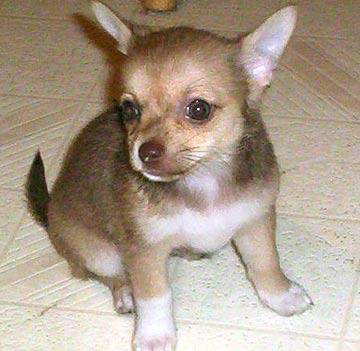

In [5]:
from PIL import Image

chihuahuas = list(data_dir.glob("*Chihuahua/*"))
Image.open(chihuahuas[0])

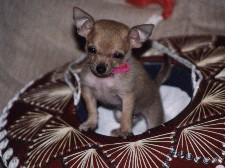

In [6]:
Image.open(chihuahuas[1])

And some Weimaraner:

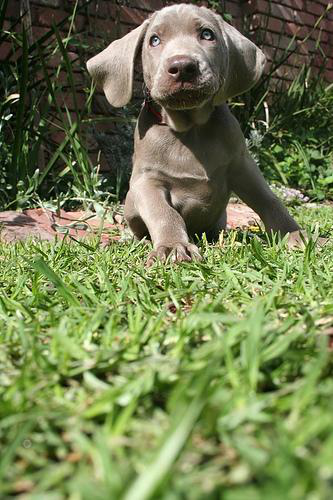

In [7]:
weimaraners = list(data_dir.glob("*Weimaraner/*"))
Image.open(weimaraners[0])

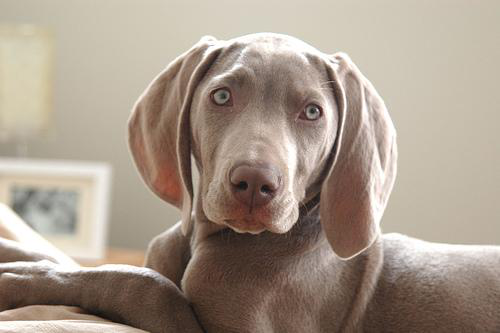

In [8]:
Image.open(weimaraners[1])

# Loading and Preprocessing Data

Basacilly, we can preprocess the data with tf.data pipline or in preprocessing layers within the model.

tf.data makes it easy to apply efficient preprocessing piplines. Howerver, the trained model will still expect preprocessed data.

On the other hand, adding preprocessing layers within the model makes the model **portable** and we will only have to write preprocessing code once for both training and inference. This is the recommended option if the model needs to be deployed.

In this part, I am going to use the first option (tf.data), but in the next part, we will use the second option since I plan to deploy the model as a REST API.

First, let's create a simple function that returns 3 lists each containing the training, validation, and testing file paths:


In [9]:
# this funtion takes from each category 20% for validation, 20% for testing, and
# the rest for training. This way we are sure to not introduce a sampling bias,
# because we have a relatively small dataset (20,580 images) compared to the number of classes (120)
def filepaths(data_dir, test_ratio=0.2, validation_ratio=0.2):
    """
    Takes the dataset directory as input and returns 
    the filepaths for training, validation, and testing
    """
    test_ratio = test_ratio
    validation_ration = validation_ratio

    train_filepaths = []
    valid_filepaths = []
    test_filepaths = []

    path = os.path.join("/root/.keras/datasets/", "Images/" )
    for i in range(n_classes):
        img_per_cat = os.listdir(data_dir / class_names[i])
        # ex: 'n02097130-giant_schnauzer/n02097130_5175.jpg'
        img_per_cat = np.array([os.path.join(class_names[i], s) for s in img_per_cat])
        
        total_size = len(img_per_cat) # ex. 157
        test_size = int(total_size * test_ratio) # ex. 31
        validation_size = int(total_size * validation_ratio) # ex. 31
        train_size = total_size - test_size - validation_size # ex. 95

        rnd_indices = np.random.permutation(total_size)

        train_filepaths.append(img_per_cat[rnd_indices[:train_size]])
        valid_filepaths.append(img_per_cat[rnd_indices[train_size:-test_size]])
        test_filepaths.append(img_per_cat[rnd_indices[-test_size:]])

    # make each path like this: 
    # '/root/.keras/datasets/Images/n02097130-giant_schnauzer/n02097130_4464.jpg'
    train_filepaths = np.array([path + s for s in np.hstack(train_filepaths)])
    valid_filepaths = np.array([path + s for s in np.hstack(valid_filepaths)])
    test_filepaths = np.array([path + s for s in np.hstack(test_filepaths)])

    return (train_filepaths, valid_filepaths, test_filepaths)

(train_filepaths, valid_filepaths, test_filepaths) = filepaths(data_dir)
train_filepaths.shape, valid_filepaths.shape, test_filepaths.shape

((12436,), (4072,), (4072,))

In [10]:
train_filepaths[:5]

array(['/root/.keras/datasets/Images/n02099429-curly-coated_retriever/n02099429_869.jpg',
       '/root/.keras/datasets/Images/n02099429-curly-coated_retriever/n02099429_1793.jpg',
       '/root/.keras/datasets/Images/n02099429-curly-coated_retriever/n02099429_1234.jpg',
       '/root/.keras/datasets/Images/n02099429-curly-coated_retriever/n02099429_121.jpg',
       '/root/.keras/datasets/Images/n02099429-curly-coated_retriever/n02099429_2281.jpg'],
      dtype='<U89')

# Standardizing the data

We will use the `Rescaling` layer to standardize pixel values between 0 and 1.

We can apply it to the dataset by calling the map function or we can include it inside the model definition (which simplify deployment). We will use the first option.





In [11]:
norm_layer = layers.experimental.preprocessing.Rescaling(1./255)

# Building an input pipeline using tf.data

In [12]:
train_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)
train_dataset = train_dataset.shuffle(1000)
for i in train_dataset.take(3):
    print(i)

tf.Tensor(b'/root/.keras/datasets/Images/n02098413-Lhasa/n02098413_387.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/Images/n02095889-Sealyham_terrier/n02095889_4116.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/Images/n02089078-black-and-tan_coonhound/n02089078_2753.jpg', shape=(), dtype=string)


We can see the length of the dataset like this:

In [13]:
tf.data.experimental.cardinality(train_dataset).numpy()

12436

Let's write a short function that converts a file path to a tensor image and its label:

In [14]:
img_height = 150
img_width = 150

def get_label(file_path):
    """Takes the label from the file path"""
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

def preprocess(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    return img, label

Putting everything together:

In [15]:
def create_dataset(filepaths, batch_size=32, buffer_size=1000):
    ds = tf.data.Dataset.list_files(filepaths, seed=42)
    ds = ds.map(preprocess, num_parallel_calls=5)
    ds = ds.map(lambda x, y: (norm_layer(x), y), num_parallel_calls=5)
    ds = ds.shuffle(buffer_size)
    ds = ds.batch(batch_size)
    return ds.prefetch(1)

In [16]:
train_set = create_dataset(train_filepaths) 
valid_set = create_dataset(valid_filepaths)
test_set = create_dataset(test_filepaths)

In [17]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch.shape)
    print(y_batch)

(32, 150, 150, 3)
tf.Tensor(
[ 22 102  48  48  21  52  83  53  30  76  76   3  45  99  51   4  31  87
  84  45  12 105  56  90 100 113  11  39  48 106   7 115], shape=(32,), dtype=int64)


# Visualizing the data

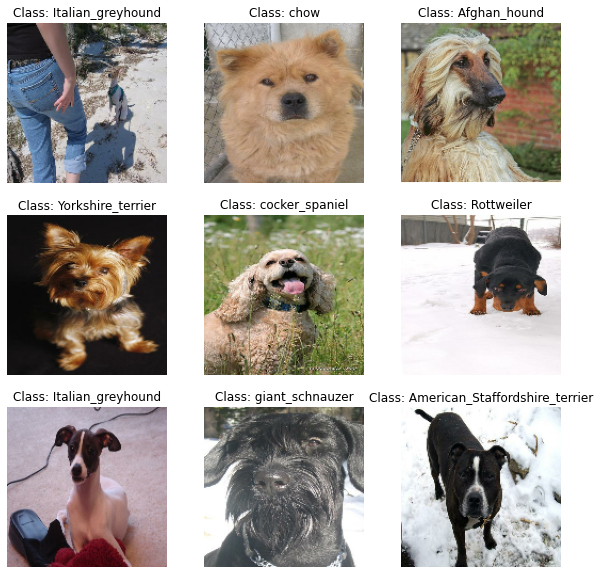

In [26]:
plt.figure(figsize=(10, 10))
for X_batch, y_batch in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X_batch[i].numpy())
        label = y_batch[i]
        plt.title("Class: " + class_names[label][10:])
        plt.axis("off")


# Create and compile the model



In [ ]:
model = models.Sequential([
    layers.Conv2D(16, 3, padding="same", activation="relu", 
                  input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(2048, activation="relu"),
    layers.Dense(n_classes, activation="softmax") # 120
])
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 64)        3

In [ ]:
epochs = 20
model.fit(train_set, epochs=epochs, validation_data=valid_set)

Epoch 1/20
389/389 [==============================] - 230s 471ms/step - loss: 4.7884 - accuracy: 0.0094 - val_loss: 4.7809 - val_accuracy: 0.0123
Epoch 2/20
389/389 [==============================] - 96s 236ms/step - loss: 4.7807 - accuracy: 0.0115 - val_loss: 4.7797 - val_accuracy: 0.0123
Epoch 3/20
389/389 [==============================] - 56s 144ms/step - loss: 4.7795 - accuracy: 0.0132 - val_loss: 4.7804 - val_accuracy: 0.0123
Epoch 4/20
389/389 [==============================] - 25s 64ms/step - loss: 4.7798 - accuracy: 0.0113 - val_loss: 4.7793 - val_accuracy: 0.0123
Epoch 5/20
389/389 [==============================] - 26s 66ms/step - loss: 4.7804 - accuracy: 0.0109 - val_loss: 4.7789 - val_accuracy: 0.0123
Epoch 6/20
389/389 [==============================] - 26s 65ms/step - loss: 4.7800 - accuracy: 0.0121 - val_loss: 4.7791 - val_accuracy: 0.0123
Epoch 7/20
389/389 [==============================] - 26s 65ms/step - loss: 4.7801 - accuracy: 0.0129 - val_loss: 4.7790 - val_accur

Our model seems to be too simple for this task. Let's stop here and try a pretrained model instead